In [21]:
import requests
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
url_grenoble = "https://archive-api.open-meteo.com/v1/archive?latitude=45.1787&longitude=5.7148&start_date=1950-01-01&end_date=2025-02-01&hourly=temperature_2m&timezone=Europe%2FBerlin"



# GRENOBLE

In [4]:
# Get response
response_gre = requests.get(url_grenoble)
response_gre = response_gre.json()
data_gre = response_gre['hourly']

# Convert to df
df_gre = pd.DataFrame(data_gre)

# Rename column
df_gre = df_gre.rename(columns={'temperature_2m':'temperature'})

# Set date format
df_gre['time'] = pd.to_datetime(df_gre['time'], utc=True)

### Temperature by day (mean)

In [44]:
# GroupBy day
df_gre_by_day = df_gre.groupby(df_gre['time'].dt.date)['temperature'].mean().reset_index()

# Save to .csv
df_gre_by_day.to_csv("../data/grenoble/meteo_gre_by_day.csv", index=False)
df_gre_by_day

,time,temperature
0,1950-01-01,1.645833
1,1950-01-02,1.520833
2,1950-01-03,3.595833
3,1950-01-04,5.829167
4,1950-01-05,5.741667
...,...,...
27421,2025-01-28,7.366667
27422,2025-01-29,5.512500
27423,2025-01-30,6.333333
27424,2025-01-31,5.383333


### Filter temperatures

In [45]:
# Filter temperatures < 0
df_gre['year'] = df_gre['time'].dt.year

# df_gre
df_gre_0 = df_gre[df_gre['temperature'] < 0]
# df_gre_0

occurrences_gre_0_per_year = df_gre_0.groupby('year').size().reset_index(name='nb_occurrences_0').set_index('year').fillna(0)


In [46]:
# Filter temperatures > 30
df_gre['year'] = df_gre['time'].dt.year
df_gre_30 = df_gre[df_gre['temperature'] > 30]

occurrences_gre_30_per_year = df_gre_30.groupby('year').size().reset_index(name='nb_occurrences_30').set_index('year')

In [47]:
# Merge dfs
final_df_occurrences = occurrences_gre_0_per_year.merge(occurrences_gre_30_per_year, on='year', how='outer')

final_df_occurrences['nb_occurrences_30'] = final_df_occurrences['nb_occurrences_30'].fillna(0)
final_df_occurrences['nb_occurrences_30'] = final_df_occurrences['nb_occurrences_30'].astype(int)

final_df_occurrences.to_csv("../data/grenoble/meteo_gre_occurrences.csv")


### Temperature by year (mean)

In [48]:
df_gre_by_year = df_gre.groupby(df_gre['time'].dt.year)['temperature'].mean().reset_index()
df_gre_by_year = df_gre_by_year.iloc[:-1]
df_gre_by_year['temperature'] = round(df_gre_by_year['temperature'], 2)
df_gre_by_year

,time,temperature
0,1950,11.64
1,1951,11.36
2,1952,11.36
3,1953,11.39
4,1954,10.58
...,...,...
70,2020,14.19
71,2021,12.74
72,2022,14.83
73,2023,14.15


In [49]:
# Base 100 en 1950
base_1950 = df_gre_by_year[df_gre_by_year['time'] == 1950]['temperature'].values[0]

# Calculer l'indice base 100
df_gre_by_year['indice_base_100'] = (df_gre_by_year['temperature'] / base_1950) * 100
df_gre_by_year['indice_base_100'] = round(df_gre_by_year['indice_base_100'], 2)
df_gre_by_year.to_csv("../data/grenoble/meteo_by_year_base100_1950.csv", index=False)

### Temperature by decade

In [50]:
# Copy df
df_gre_by_year_decade = df_gre_by_year.copy()

# Ajouter une colonne "décennie" en arrondissant l'année à la dizaine inférieure
df_gre_by_year_decade['decade'] = (df_gre_by_year_decade['time'] // 10) * 10

# GroupBy decade
df_gre_by_year_decade = df_gre_by_year_decade.groupby('decade')['temperature'].mean().reset_index()

base_decade_1950 = df_gre_by_year_decade[df_gre_by_year_decade['decade'] == 1950]['temperature'].values[0]
df_gre_by_year_decade['indice_base_100'] = round((df_gre_by_year_decade['temperature'] / base_decade_1950) * 100, 2)

df_gre_by_year_decade.to_csv("../data/grenoble/meteo_by_year_base100_decade.csv", index=False)

### Temperature rolling average 5 years

In [51]:
df_gre_rolling = df_gre_by_year.copy()
df_gre_rolling['rolling_avg_5y'] = round(df_gre_rolling['temperature'].rolling(window=5).mean(), 2).fillna(0)

df_gre_rolling.to_csv("../data/grenoble/meteo_by_year_rolling.csv", index=False)

df_gre_rolling

,time,temperature,indice_base_100,rolling_avg_5y
0,1950,11.64,100.00,0.00
1,1951,11.36,97.59,0.00
2,1952,11.36,97.59,0.00
3,1953,11.39,97.85,0.00
4,1954,10.58,90.89,11.27
...,...,...,...,...
70,2020,14.19,121.91,13.53
71,2021,12.74,109.45,13.54
72,2022,14.83,127.41,13.88
73,2023,14.15,121.56,13.90


### Top 5 increase - decrease

In [52]:
df_gre_max_increase_decrease = df_gre_rolling.copy()
df_gre_max_increase_decrease = df_gre_max_increase_decrease.drop(columns=['rolling_avg_5y', 'indice_base_100'])
df_gre_max_increase_decrease['temperature_change'] = df_gre_max_increase_decrease['temperature'].diff()
# df_gre_max_increase_decrease


# Top 5 increase temperature from one year to another
top5_increase = df_gre_max_increase_decrease.nlargest(5, 'temperature_change')[['time', 'temperature_change']]
top5_increase = top5_increase.rename(columns={'temperature_change':'increase', 'time': 'time_increase'})
top5_increase

,time_increase,increase
72,2022,2.09
61,2011,2.06
64,2014,1.46
14,1964,1.33
7,1957,1.32


In [53]:
# Top 5 decrease temperature from one year to another
top5_decrease = df_gre_max_increase_decrease.nsmallest(5, 'temperature_change')[['time', 'temperature_change']]
top5_decrease = top5_decrease.rename(columns={'temperature_change':'decrease', 'time': 'time_decrease'})
top5_decrease


,time_decrease,decrease
12,1962,-1.62
60,2010,-1.53
6,1956,-1.47
71,2021,-1.45
54,2004,-1.19


### Temperatures range by day

In [54]:
df_amplitude = df_gre.copy()
df_amplitude['time'] = df_amplitude['time'].dt.date
daily_temp = df_amplitude.groupby('time')['temperature'].agg(Tmax='max', Tmin='min')
daily_temp['amplitude'] = daily_temp['Tmax'] - daily_temp['Tmin']
daily_temp

,Tmax,Tmin,amplitude
time,,,
1950-01-01,4.8,-0.1,4.9
1950-01-02,5.5,-1.9,7.4
1950-01-03,5.5,2.0,3.5
1950-01-04,6.5,4.9,1.6
1950-01-05,7.3,4.5,2.8
...,...,...,...
2025-01-28,11.2,5.2,6.0
2025-01-29,12.6,1.2,11.4
2025-01-30,9.7,3.1,6.6


### Temperature range by month

In [55]:
df_amplitude_month = df_gre.copy()
df_amplitude_month['year_month'] = df_amplitude_month['time'].dt.to_period(freq='M')
df_amplitude_month = df_amplitude_month.groupby('year_month')['temperature'].agg(Tmax='max', Tmin='min')
df_amplitude_month['amplitude'] = df_amplitude_month['Tmax'] - df_amplitude_month['Tmin']
df_amplitude_month

/tmp/ipykernel_10903/2187709164.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_amplitude_month['year_month'] = df_amplitude_month['time'].dt.to_period(freq='M')


,Tmax,Tmin,amplitude
year_month,,,
1950-01,11.2,-9.9,21.1
1950-02,18.5,-6.4,24.9
1950-03,18.0,-7.4,25.4
1950-04,21.4,-2.0,23.4
1950-05,31.2,5.3,25.9
...,...,...,...
2024-10,29.5,5.9,23.6
2024-11,21.5,-0.9,22.4
2024-12,15.9,-5.4,21.3


In [56]:
df_amplitude_month_filtered = df_gre.copy()
df_amplitude_month_filtered['year_month'] = df_amplitude_month_filtered['time'].dt.to_period(freq='M')
df_amplitude_month_filtered = df_amplitude_month_filtered[df_amplitude_month_filtered['year_month'].dt.month.isin([1,2,7,8])]
monthly_temp = df_amplitude_month_filtered.groupby('year_month')['temperature'].agg(Tmax='max', Tmin='min')
monthly_temp['amplitude'] = monthly_temp['Tmax'] - monthly_temp['Tmin']
monthly_temp

/tmp/ipykernel_10903/2012177327.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_amplitude_month_filtered['year_month'] = df_amplitude_month_filtered['time'].dt.to_period(freq='M')


,Tmax,Tmin,amplitude
year_month,,,
1950-01,11.2,-9.9,21.1
1950-02,18.5,-6.4,24.9
1950-07,35.3,14.5,20.8
1950-08,32.1,11.4,20.7
1951-01,9.7,-8.0,17.7
...,...,...,...
2024-02,19.6,-0.6,20.2
2024-07,35.5,13.6,21.9
2024-08,36.3,13.4,22.9


### Number of days above 15º by year

In [57]:
df_above_15 = df_gre_by_day.copy()
df_above_15['time'] = pd.to_datetime(df_above_15['time'], utc=True)
df_above_15 = df_above_15[df_above_15['temperature'] >= 15]
df_above_15['year'] = df_above_15['time'].dt.year
df_above_15_by_year = df_above_15.groupby('year')['temperature'].count().reset_index(name='nb_occurrences_above_15')
df_above_15_by_year

,year,nb_occurrences_above_15
0,1950,146
1,1951,122
2,1952,140
3,1953,138
4,1954,117
...,...,...
70,2020,162
71,2021,148
72,2022,178
73,2023,166


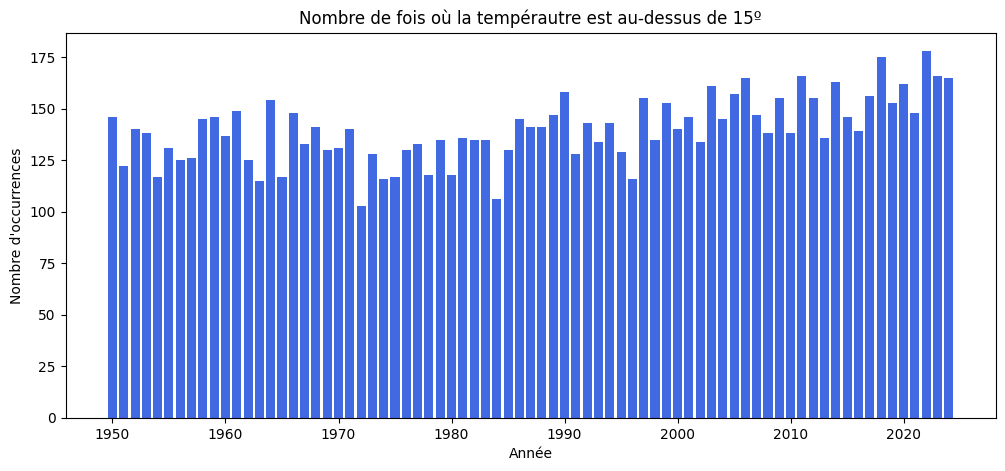

In [36]:
plt.figure(figsize=(12,5))
plt.bar(df_above_15_by_year['year'], df_above_15_by_year['nb_occurrences_above_15'], color='royalblue')
plt.xlabel('Année')
plt.ylabel("Nombre d'occurrences")
plt.title('Nombre de fois où la température est au-dessus de 15º')
plt.show()

### Number of days above 15º by decade

In [42]:
df_above_15_by_decade = df_above_15_by_year.copy()
df_above_15_by_decade['decade'] = (df_above_15_by_decade['year'] // 10) * 10
df_above_15_by_decade = df_above_15_by_decade.groupby(df_above_15_by_decade['decade'])['nb_occurrences_above_15'].sum().reset_index()
df_above_15_by_decade

,decade,nb_occurrences_above_15
0,1950,1336
1,1960,1349
2,1970,1251
3,1980,1334
4,1990,1394
5,2000,1488
6,2010,1527
7,2020,819


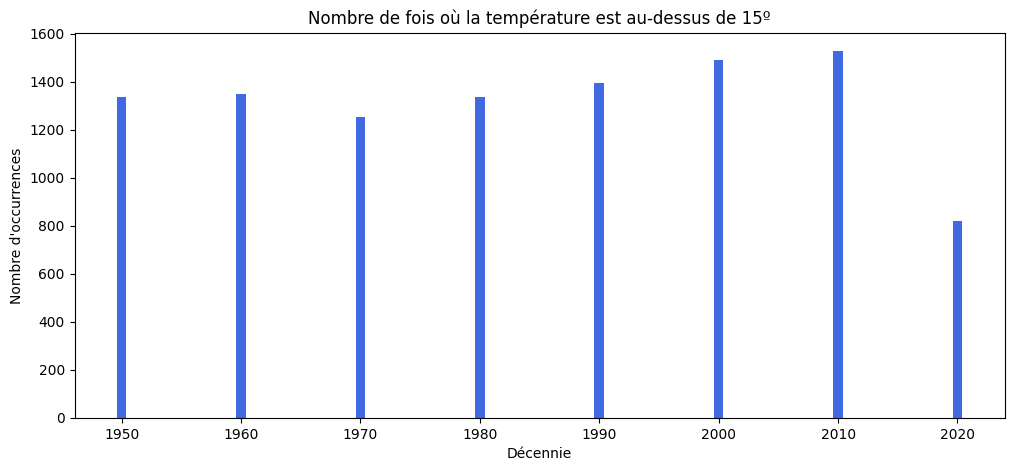

In [43]:
plt.figure(figsize=(12,5))
plt.bar(df_above_15_by_decade['decade'], df_above_15_by_decade['nb_occurrences_above_15'], color='royalblue')
plt.xlabel('Décennie')
plt.ylabel("Nombre d'occurrences")
plt.title('Nombre de fois où la température est au-dessus de 15º')
plt.show()